In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from matplotlib import patches

sys.path.append('..')#
from util import add_angles, angle_between, angled_vector, sub_angles

In [2]:
def get_rotation_matrix(angle):
    c = np.cos(angle)
    s = np.sin(angle)
    R = np.array([c, -s, s, c]).reshape(2,2)
    return R

In [3]:
R = get_rotation_matrix(np.deg2rad(270))
R @ np.array([1,0])

array([ -1.83697020e-16,  -1.00000000e+00])

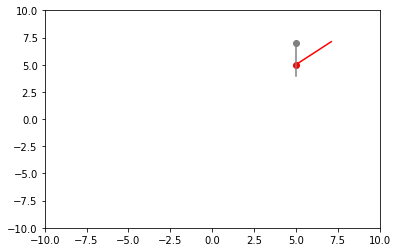

In [4]:
def plot_grid(p1, p2, traj1, traj2):
    fig, ax = plt.subplots()
    ax.scatter(p1[0], p1[1], c='r')
    ax.scatter(p2[0], p2[1], c='gray')

    ax.plot([p1[0], p1[0] + traj1[0]], [p1[1], p1[1] + traj1[1]], c='r')
    ax.plot([p2[0], p2[0] + traj2[0]], [p2[1], p2[1] + traj2[1]], c='gray')

    ax.set_xbound(-10, 10)
    ax.set_ybound(-10, 10)
    

pos1, pos2 = np.array([5,5]), np.array([5,7])
ang1, ang2 = np.deg2rad([45, -90])
traj1, traj2 = angled_vector(ang1) * 3, angled_vector(ang2) * 3

plot_grid(pos1, pos2, traj1, traj2)

-135.0

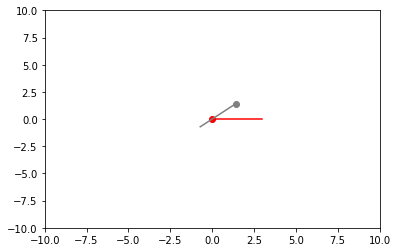

In [5]:
# RF
# 1. Rotate coord system.
R = get_rotation_matrix(-ang1)
pos1_rot = R @ pos1.reshape(2,1)
pos2_rot = R @ pos2.reshape(2,1)
traj1_rot = R @ traj1
traj2_rot = R @ traj2
# 2. Set p1 at center (0,0) and adjust other
pos2_rot -= pos1_rot
pos1_rot = np.array([0.0, 0.0])
ang1_rot = 0.0
ang2_rot = ang2 - ang1
# 3. Plot
plot_grid(pos1_rot, pos2_rot, traj1_rot, traj2_rot)

np.rad2deg(ang2_rot)

In [6]:
df_kicks_tr = pd.read_csv('../../data/processed/kicks_guy_train.csv')
df_kicks_te = pd.read_csv('../../data/processed/kicks_guy_test.csv')

In [11]:
from itertools import product
# Compute relative coords/angles
def transform_coords_row(row):
    rotation_angle = row['rotation_angle']
    rotation_matrix = get_rotation_matrix(-rotation_angle)
    
    pos_f0 = np.array([row['x_f0'], row['y_f0']])
    pos_f1 = np.array([row['x_f1'], row['y_f1']])
    
    # Rotate both fish s.t. fish 0 has angle 0
    pos_f0 = (rotation_matrix @ pos_f0.reshape(2,1))
    pos_f1 = (rotation_matrix @ pos_f1.reshape(2,1))
    
    # Put fish zero at (0,0) in coord system
    pos_f1 = (pos_f1 - pos_f0).reshape(2)
    pos_f0 = np.array([0,0])

    angle_f1 = sub_angles(row['angle_f1'], rotation_angle)
    
    row = pd.Series(data=[row['dt'], row['heading_change'], pos_f1[0], pos_f1[1], angle_f1],
                    index=['dt', 'heading_change', 'x_f1', 'y_f1', 'angle_f1'])
    return row


def prepare_df(df, cutoff_wall_range = 7):
    # Group columns by kick (dt=0,1,..)
    max_dt = df['dt'].max() + 1
    
    assert(len(df) % max_dt == 0)
    num_kicks = len(df)//max_dt
    groups = np.repeat(np.arange(0, num_kicks), max_dt)
    df['group'] = pd.Series(groups, index=df.index)

    # Consider only a small subsample of data here.
    # Drop all kicks where one timestep is too close to the wall
    wall_dist_col = [f'wall_distance{i}_f{id}' for i, id in product(range(0,4), range(0,2))]
    min_wall_dist = df[wall_dist_col].min(axis=1)

    # TODO: Maybe only drop when dt=0 is not close to wall.
    groups_to_keep = np.unique(df.loc[(min_wall_dist > cutoff_wall_range),'group'])
    to_keep = df['group'].isin(groups_to_keep)

    df = df.loc[to_keep,:]
    df = df[['dt', 'heading_change', 'x_f0', 'y_f0', 'x_f1', 'y_f1', 'angle_f0', 'angle_f1']]

    # Add angle of fish zero at start of kick
    is_kick = df['dt'] == 0
    rotating_angle = np.repeat(df.loc[is_kick, 'angle_f0'].values, max_dt)
    # TODO: Fish zero for all dt at (0,0)
    #df.loc[:,'rotation_angle'] = pd.Series(rotating_angle, index=df.index)
    df.loc[:, 'rotation_angle'] = df['angle_f0']
    
    # Reshape 
    df = df.apply(transform_coords_row, axis=1)
    
    # Fix index (not seq. due to dropping earlier!)
    df.index = pd.Index(range(0, len(df)))

    return df

df_train = prepare_df(df_kicks_tr.copy())
df_test = prepare_df(df_kicks_te.copy())
max_dt = int(df_train['dt'].max())
print(len(df_train), max_dt)

20337 2


In [74]:
def get_bins(df, num_bins=7):
    # Build symmetric receptive field.
    rf_size = max(df['x_f1'].abs().max(), df['y_f1'].abs().max())
    
    # RF has size rf_size x rf_size, each direction divided by num_bins
    # Should be of form 2n-1 (symmetric in pos/neg. direction, centered at (0,0))
    assert(((num_bins-1) % 2) == 0)
    
    b = np.linspace(rf_size, 0, num=num_bins//2, endpoint=False)
    #b = np.array([rf_size/(i+1) for i in range(num_bins//2)])
    bins = np.hstack((-b,[0], b[::-1]))
    
    return bins

num_bins = 7
bins = get_bins(df_train, num_bins)
def get_bin(df, bins):
    # TODO: Open intervals on both sides!
    bin_x = np.digitize(df['x_f1'], bins=bins) - 1
    bin_y = np.digitize(df['y_f1'], bins=bins) - 1
    
    # Clip to range
    bin_x = bin_x.clip(0, num_bins-1)
    bin_y = bin_y.clip(0, num_bins-1)
    return (bin_x*len(bins)) + bin_y

df_train['bin'] = pd.Series(get_bin(df_train, bins), index=df_train.index)
df_test['bin'] = pd.Series(get_bin(df_test, bins), index=df_test.index)

bins, np.ediff1d(bins), df_train['bin'].min(), df_test['bin'].min(), 

(array([-8.88278464, -5.92185643, -2.96092821,  0.        ,  2.96092821,
         5.92185643,  8.88278464]),
 array([ 2.96092821,  2.96092821,  2.96092821,  2.96092821,  2.96092821,
         2.96092821]),
 2,
 1)

In [33]:
# Adaptively sized bins
# Should have same number of fish in each bin.

# Idea:
# First compute quantiles for x then for y direction.
# Because we need a symmetric receptive field, just compute quantiles
# of the absolute value.

from scipy import stats
#df = df_train.loc[df_train['dt']==0, :].copy()
assert(False) # TODO: Remove

x_dist = np.abs(df['x_f1'])
y_dist = np.abs(df['y_f1'])

#del df


prob = [i/((num_bins//2)+1) for i in range(0,num_bins//2 + 2)]

edges_x = stats.mstats.mquantiles(x_dist, prob=prob)
edges_y = stats.mstats.mquantiles(y_dist, prob=prob)

# Reset left edge
edges_x[0] = 0
edges_y[0] = 0

# TODO: Remove absolute value here!
bins_x = np.digitize(x_dist, bins=edges_x, right=True) - 1
bins_y = np.digitize(y_dist, bins=edges_y, right=True) - 1
bins = (bins_x*len(edges_x)) + bins_y
#np.unique(np.digitize(y_dist, edges, right=True), return_counts=True)
np.unique(bins, return_counts=True)

AssertionError: 

In [17]:
def bin_one_dim(array, num_bins):
# Inspired by np.array_split
# https://github.com/numpy/numpy/blob/v1.14.0/numpy/lib/shape_base.py#L431-L483
# Divide into equal bins, if not possible first few bins have size + 1
    
    a = np.sort(array)
    assert(np.signbit(a[0]) == np.signbit(a[-1]))
    num_per_bin, extras = divmod(len(a), num_bins)
    section_sizes = [0] + extras * [num_per_bin+1] + (num_bins-extras) * [num_per_bin]
    div_ind = np.array(section_sizes).cumsum()
    div_ind[-1] -= 1
    div_ind, len(a)
    bin_edges = a[div_ind]
    if (np.signbit(a[0])):
        bin_edges[-1] = 0.0
    else:
        bin_edges[0] = 0.0
    return bin_edges

assert(False)

x_dist = np.abs(df_train['x_f1'])
y_dist = np.abs(df_train['y_f1'])

print(bin_one_dim(array=x_dist, num_bins=num_bins),\
bin_one_dim(array=y_dist, num_bins=num_bins), sep='\n')

edges_x = bin_one_dim(np.abs(df_train['x_f1']), num_bins)
print(np.unique(np.digitize(np.abs(df_train.loc[df_train['x_f1'] > 0,'x_f1']) ,edges_x, right=True), return_counts=True),\
np.unique(np.digitize(np.abs(df_train.loc[df_train['x_f1'] < 0,'x_f1']) ,edges_x, right=True), return_counts=True),\
     sep='\n')

AssertionError: 

In [31]:
assert(False)
bins_x = np.digitize(np.abs(df_train['x_f1']), edges_x, right=True) - 1
df_train.loc[:, 'bin_x'] = pd.Series(bins_x, index=df.index)
print(np.unique(bins_x, return_counts=True))

cur_y_dist = df.loc[df['bin_x'] == 0, 'y_f1'].abs().values
cur_edges_y = bin_one_dim(cur_y_dist, num_bins)
print(cur_edges_y)
cur_bins_y = np.digitize(cur_y_dist, cur_edges_y, right=True) - 1
np.unique(cur_bins_y, return_counts=True)

AssertionError: 

1271.0625 73.4697801395
323.25 97.9307791248
15 15


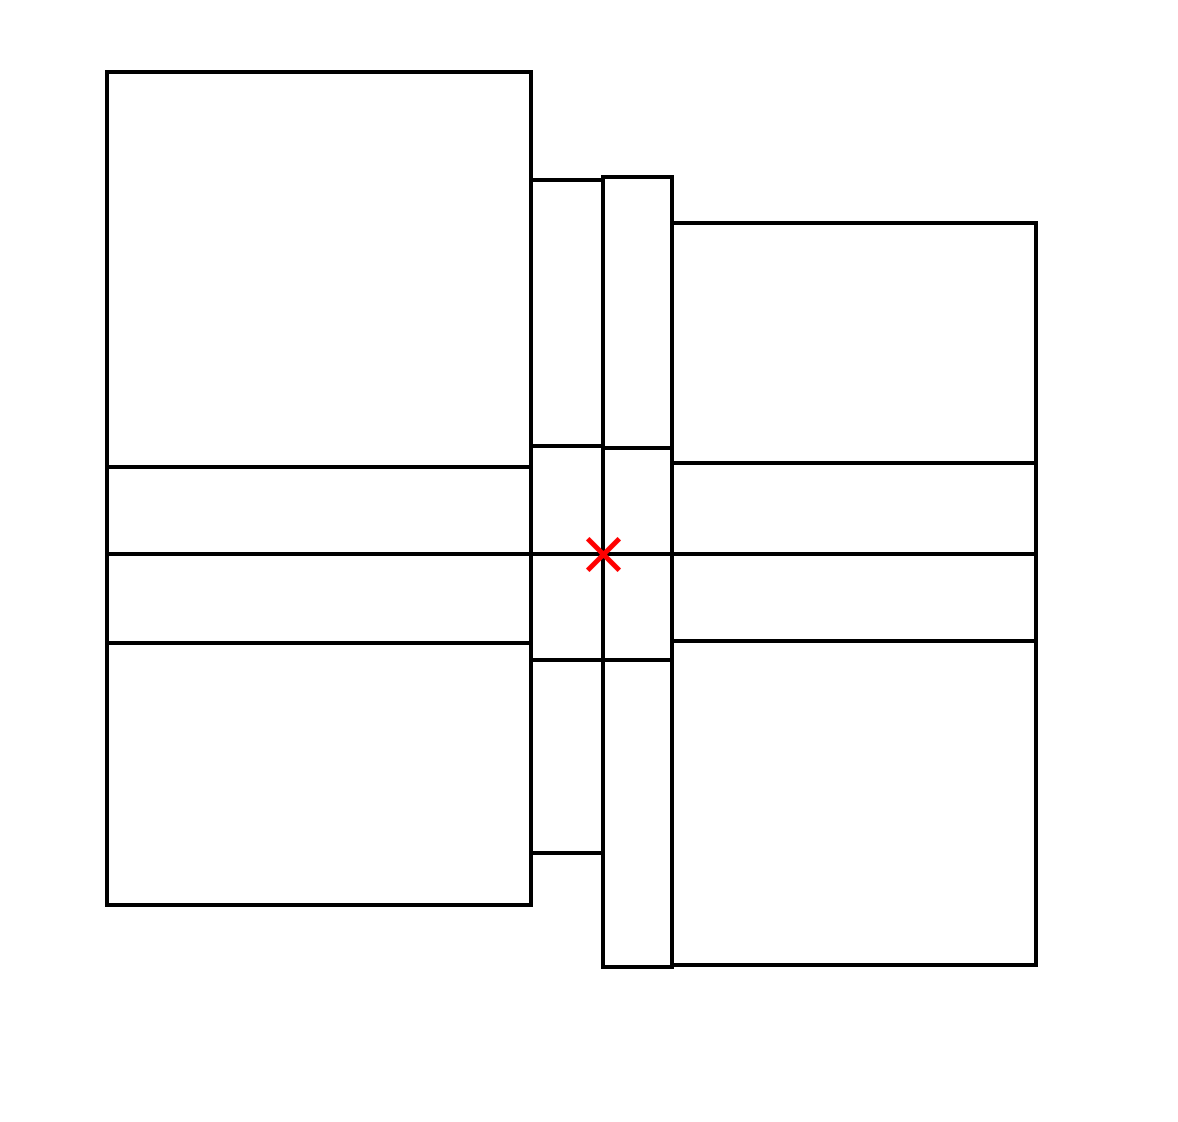

In [61]:
# Try without symmetry
def bin_axis(array, num_bins):
    assert(num_bins % 2 == 0)
    #num_bins += 1
    dist_pos = array[array >= 0]
    dist_neg = array[array < 0]
    edges_pos = bin_one_dim(dist_pos, num_bins//2)
    edges_neg = bin_one_dim(dist_neg, num_bins//2)#[::-1]
    edges = np.hstack((edges_neg, edges_pos[1:]))
    
    # Fix empty bins on either side (make bit larger than data range)
    eps = 10e-6
    edges[0] -= eps
    edges[-1] += eps
    return edges

def bin_df(df, num_bins=6):
    edges_x = bin_axis(df['x_f1'].values, num_bins)
    bins_x = np.digitize(df['x_f1'].values, edges_x, right=False) - 1
    #bins_y = np.zeros_like(bins_x) - 1 # invalid bins for now!

    edges_y = np.zeros((num_bins, num_bins+1))

    for i in range(num_bins):
        is_in_bin = bins_x == i
        cur_y = df.loc[is_in_bin,'y_f1'].values
        cur_edges_y = bin_axis(cur_y, num_bins)
        edges_y[i,:] = cur_edges_y
        #cur_bins_y = np.digitize(df.loc[is_in_bin, 'y_f1'].values, cur_edges_y, right=False) - 1
        #bins_y[is_in_bin] = cur_bins_y

    #bins = (bins_x*num_bins) + bins_y
    #df.loc[:,'bin'] = pd.Series(bins, index=df.index)

    return edges_x, edges_y

def get_bins_df(df, edges_x, edges_y):
    bins_x = np.digitize(df['x_f1'].values, edges_x, right=False) - 1
    bins_x = bins_x.clip(0, len(edges_x) - 2) # todo
    bins_y = np.zeros_like(bins_x) - 1 # invalid bins for now!

    for i in range(num_bins):
        is_in_bin = bins_x == i
        #cur_y = df.loc[is_in_bin,'y_f1'].values
        #cur_edges_y = bin_axis(cur_y, num_bins)
        #edges_y[i,:] = cur_edges_y
        cur_bins_y = np.digitize(df.loc[is_in_bin, 'y_f1'].values,
                                 edges_y[i,:],
                                 right=False) - 1
        cur_bins_y = cur_bins_y.clip(0, len(edges_x) - 2) # todo
        bins_y[is_in_bin] = cur_bins_y

    bins = (bins_x*num_bins) + bins_y
    df.loc[:,'bin'] = pd.Series(bins, index=df.index)    
    
    print(np.unique(bins,return_counts=True)[1].mean(), np.unique(bins,return_counts=True)[1].std())

    return df

num_bins=4
edges_x, edges_y = bin_df(df_train, num_bins=num_bins)
df_train = get_bins_df(df_train, edges_x=edges_x, edges_y=edges_y)
df_test = get_bins_df(df_test, edges_x=edges_x, edges_y=edges_y)

from matplotlib import cm
from matplotlib.colors import Normalize

# See: https://stackoverflow.com/questions/20144529/shifted-colorbar-matplotlib/20146989#20146989
class DivergentNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, clip=False):
        Normalize.__init__(self, vmin, vmax, clip)
        print(self.vmax, self.vmin)
        
    def __call__(self, value, clip=None):
        x, y = [self.vmin, 0.0, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

def plot_bins(edges_x, edges_y, weights=None, weights_range=None, fig=None, ax=None):
    nun_bins = len(edges_x) - 1
    edge_x_sizes = np.ediff1d(edges_x)

    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(20,20))        
    
    if weights is None:
        color = lambda x: 'white'
    else:
        if weights_range is None:
            vmin, vmax = weights.min(), weights.max()
        else:
            vmin, vmax = weights_range
        norm = DivergentNormalize(vmin=vmin, vmax=vmax)
        mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdBu)
        mapper.set_array(weights)
        def color(x):
            w = weights[x]
            return mapper.to_rgba(w)
        
    for i, edge_x in enumerate(edges_x[:-1]):
        cur_y_edges = edges_y[i, :]
        cur_edge_y_sizes = np.ediff1d(cur_y_edges)    
        for j, edge_y in enumerate(cur_y_edges[:-1]):
            ax.add_patch(
                patches.Rectangle(
                (edge_x, edge_y),
                edge_x_sizes[i],
                cur_edge_y_sizes[j],
                fill=True,
                facecolor=color(i*num_bins + j),
                edgecolor='black',
                linewidth=4))

    # TODO: Don't hardcore!
    ax.set_xlim(-10, 10)
    ax.set_ylim(-10, 10)

    ax.scatter(0,0, c='red', s=1000, marker='x', zorder=10, linewidth=5)
    ax.axis('off')
    
    if weights is not None:
        return mapper # for colorbar
    #if weights is not None:
    #    ax.colorbar(mapper)    

plot_bins(edges_x, edges_y, None)
print(df_train['bin'].max(), df_test['bin'].max())

0.642289340982 -0.441757077357
0.642289340982 -0.441757077357


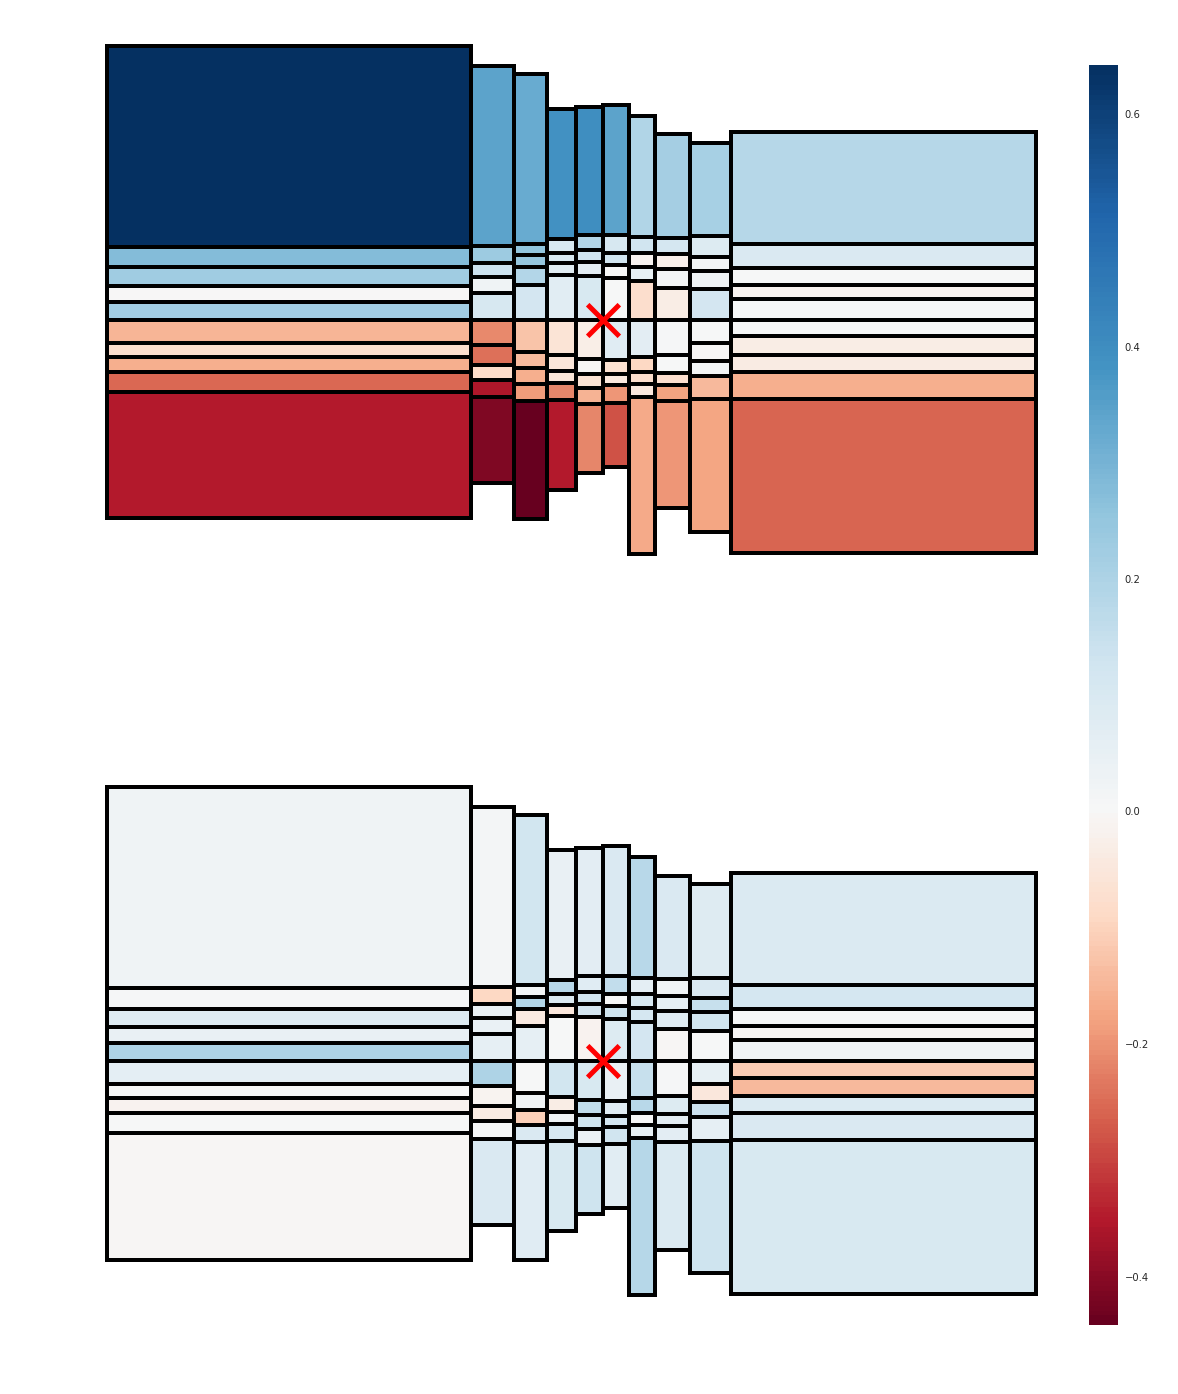

In [58]:
coef = linear.coef_
spatial_weights = coef[:num_bins**2]
angular_weights = coef[num_bins**2:]

weights_range = coef.min(), coef.max()

fig, ax = plt.subplots(2, figsize=(20,25), sharex=True)
_ = plot_bins(edges_x, edges_y, spatial_weights, fig=fig, ax=ax[0], weights_range=weights_range)
mapper = plot_bins(edges_x, edges_y, angular_weights, fig=fig, ax=ax[1], weights_range=weights_range)

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(mapper, cax=cbar_ax)

#fig.savefig('../../figures/adap_linear.pdf', transparent=True, bbox_inches='tight')

In [75]:
import sklearn.preprocessing as pre

def get_Xy(df, num_bins):
    # Scale angle:
    angle_scaler = pre.StandardScaler()
    angle_scaled = angle_scaler.fit_transform(X=df['angle_f1'].values.reshape(-1,1)).reshape(-1)

    # Now we need to one-hot enccode our data.
    # We need one column per variable and bin

    # Indicator for position
    # We need this because some bins could be unoccupied in training but occupied in testing!
    one_hot_enc = pre.OneHotEncoder()
    one_hot_enc.fit(np.array(range(0,num_bins**2)).reshape(-1,1))
    
    position_one_hot = one_hot_enc.transform(df.loc[0:, 'bin'].reshape(-1,1)).toarray()
    
    #position_one_hot = pd.get_dummies(df['bin'])
    # Mean of angle for bin
    #angle_one_hot = pd.get_dummies(df['bin']).values * angle_scaled[:, None]
    angle_one_hot = position_one_hot * angle_scaled[:, None]

    X = np.concatenate((position_one_hot, angle_one_hot), axis=1)
    #X = position_one_hot.values
    y = df['heading_change'].values
    return X, y

use_temporal = False
X_np, y_np = get_Xy(df_train, num_bins=num_bins)
X_np_test, y_np_test = get_Xy(df_test, num_bins=num_bins)
y_np =  y_np[df_train['dt'] == 0] # heading change at kick
y_np_test =  y_np_test[df_test['dt'] == 0] # heading change at kick
if use_temporal:
    assert(False) # todo
    Xs = []
    for dt in range(max_dt):
        Xs.append(X_np[df_train['dt'] == dt])
    # Use past as additional features.
    X_np = np.hstack(Xs)
else:
    X_np  = X_np[df_train['dt'] == 0]
    X_np_test = X_np_test[df_test['dt'] == 0]
print(X_np.shape, y_np.shape)

(6779, 98) (6779,)


/home/lukas/bin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


In [76]:
import torch
from torch.autograd import Variable
from torch.utils import data
from torch import nn
from torch import optim
from torch.utils import data

nn_model = 'lstm'

X, y = get_Xy(df_train, num_bins=num_bins+1)
Xs = []
ys = []
# TODO: Check direction of sequence.
for dt in reversed(range(max_dt)):
    cur_x, cur_y = X[df_train['dt'] == dt], y[df_train['dt'] == dt]
    Xs.append(torch.from_numpy(cur_x))
    ys.append(torch.from_numpy(cur_y))
X = torch.stack(Xs).float()
y = torch.from_numpy(y_np).float()

class LSTMDataset(data.Dataset):
    def __init__(self, X, y):
        super(data.Dataset, self).__init__
        
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[1]
    
    def __getitem__(self, idx):
        return X[:, idx,:], y[idx]


#train = data.TensorDataset(data_tensor=X, target_tensor=y)
train = LSTMDataset(X=X, y=y)

def collate(batch):
    #print(len(batch))
    result = []
    Xs = []
    ys = []
    for elem in batch:
        X = elem[0]
        y = elem[1]
        Xs.append(X)
        ys.append(y)
    return torch.stack(Xs, dim=1), torch.Tensor(np.array(ys))

train_data = data.DataLoader(train, batch_size=512, collate_fn=collate, pin_memory=True)

/home/lukas/bin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  app.launch_new_instance()


In [22]:
class LinearRF(nn.Module):
    def __init__(self, num_features, n_dt):
        super().__init__()
        # Treat each timestep as independent feature!
        self.num_features = num_features * n_dt
        self.linear = nn.Linear(in_features=self.num_features,
                                out_features=1)  
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.fill_(0.0)
        
    def forward(self, x):
        batch_size = x.shape[1]
        # Permute tensor to shape (batch_size, feature_size, sequence_size)
        x = x.permute(dims=[1,2,0])
        # Concatenate entire sequence and use as one feature
        x = x.contiguous().view(batch_size, self.num_features)
        return self.linear(x)

class MlpRF(nn.Module):
    def __init__(self, num_features, n_dt):
        super().__init__()
        n_hidden=512
        linear_out = nn.Linear(in_features=n_hidden, out_features=1, bias=True)  
        self.layers = nn.Sequential(*[
            nn.Linear(in_features=num_features, out_features=n_hidden),
            nn.Dropout(p=0.1),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=n_hidden, out_features=n_hidden),
            nn.Dropout(p=0.1),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=n_hidden, out_features=n_hidden),
            nn.Dropout(p=0.1),
            nn.ReLU(inplace=True),
            linear_out])
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.fill_(0.05)
        
    def forward(self, x):
        return self.layers(x)    

class Recurrent(nn.Module):
    def __init__(self, num_features, num_dt):
        super().__init__()
        self.hidden_size = 64
        
        self.num_features = num_features
        self.lin_in = nn.Linear(in_features=num_features, out_features=num_features)
        self.relu = nn.ReLU(inplace=True)
        self.rnn = nn.GRU(input_size=num_features, hidden_size=self.hidden_size,
                         num_layers=3, dropout=0.2)  
        self.lin_out = nn.Linear(in_features=self.hidden_size*num_dt, out_features=1)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data.normal_(0.0, 0.02)
                m.bias.data.fill_(0.0)             
                
    def forward(self, x):
        batch_size = x.shape[1]
        
        # Preprocess features
        x = self.relu(self.lin_in(x))
        
        # Work over sequence
        x, _ = self.rnn(x)
        
        # Reshape from (seq, batch, feat) to (batch, seq * feat)
        x = x.permute(dims=[1,2,0])
        x = x.contiguous().view(batch_size, -1)
        
        # Transform features to singular output.
        x = self.lin_out(x)
        return x
    
nn_model = 'lstm'
if nn_model == 'linear':
    model = LinearRF(num_features=X.shape[-1], n_dt=3).cuda()#int(max_dt)).cuda()
elif nn_model == 'mlp':
    model = MlpRF(num_features=X.shape[-1]).cuda()
elif nn_model == 'lstm':
    model = Recurrent(num_features=X.shape[-1], num_dt=int(max_dt)).cuda()
else:
    assert(False)
    
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-2)

In [88]:
num_epochs = 500
for epoch in range(num_epochs):
    cur_loss = 0.0
    for batch in train_data:
        x_batch, y_batch = [Variable(b.float().cuda()) for b in batch]
        #print(x_batch.shape, y_batch.shape)

        optimizer.zero_grad()
        
        y_hat = model(x_batch).squeeze()
        #print(y_hat.shape, y_batch.shape)
        loss = torch.sum((y_hat - y_batch)**2)
        loss.backward()
        
        optimizer.step()
        
        cur_loss += loss.data[0]       
    if (epoch % 100) == 0:
        print(cur_loss/len(X))
        
nn_yhat = model(Variable(X.cuda())).cpu().data.numpy()
nn_r2 = metrics.r2_score(y_true=y_np, y_pred=nn_yhat)
nn_r2

NameError: name 'train_data' is not defined

In [77]:
import sklearn.linear_model as lm
l1_ratios = [0.01, 0.05, 0.9, 0.95, 0.975, 0.99, 1.0]
#l1_ratios = 0.95
linear = lm.ElasticNetCV(l1_ratio=l1_ratios,n_jobs=16, max_iter=50000)
linear = linear.fit(X_np,y_np)
linear.score(X_np, y_np), linear.l1_ratio_

(0.16451784671875391, 0.050000000000000003)

In [78]:
linear.coef_.shape, linear.intercept_, linear.l1_ratio

((98,), 0.046662802315288666, [0.01, 0.05, 0.9, 0.95, 0.975, 0.99, 1.0])

In [83]:
#bins = np.unique(df_train.loc[df_train['dt']==0,'bin'])
# id = (bin_x*len(bins)) + bin_y
coords = np.array([(b//num_bins) for b in bins])

#nn_coef = model.linear.weight.data.cpu().numpy()

spatial = linear.coef_[0:num_bins**2]
angular = linear.coef_[num_bins**2:]

#bins.shape, spatial.shape
spatial_weights = np.zeros((num_bins*num_bins))
spatial_weights = spatial
spatial_weights = spatial_weights.reshape(num_bins,num_bins)

angular_weights = np.zeros((num_bins*num_bins))
angular_weights = angular
angular_weights = angular_weights.reshape(num_bins,num_bins)

spatial.shape, angular.shape

((49,), (49,))

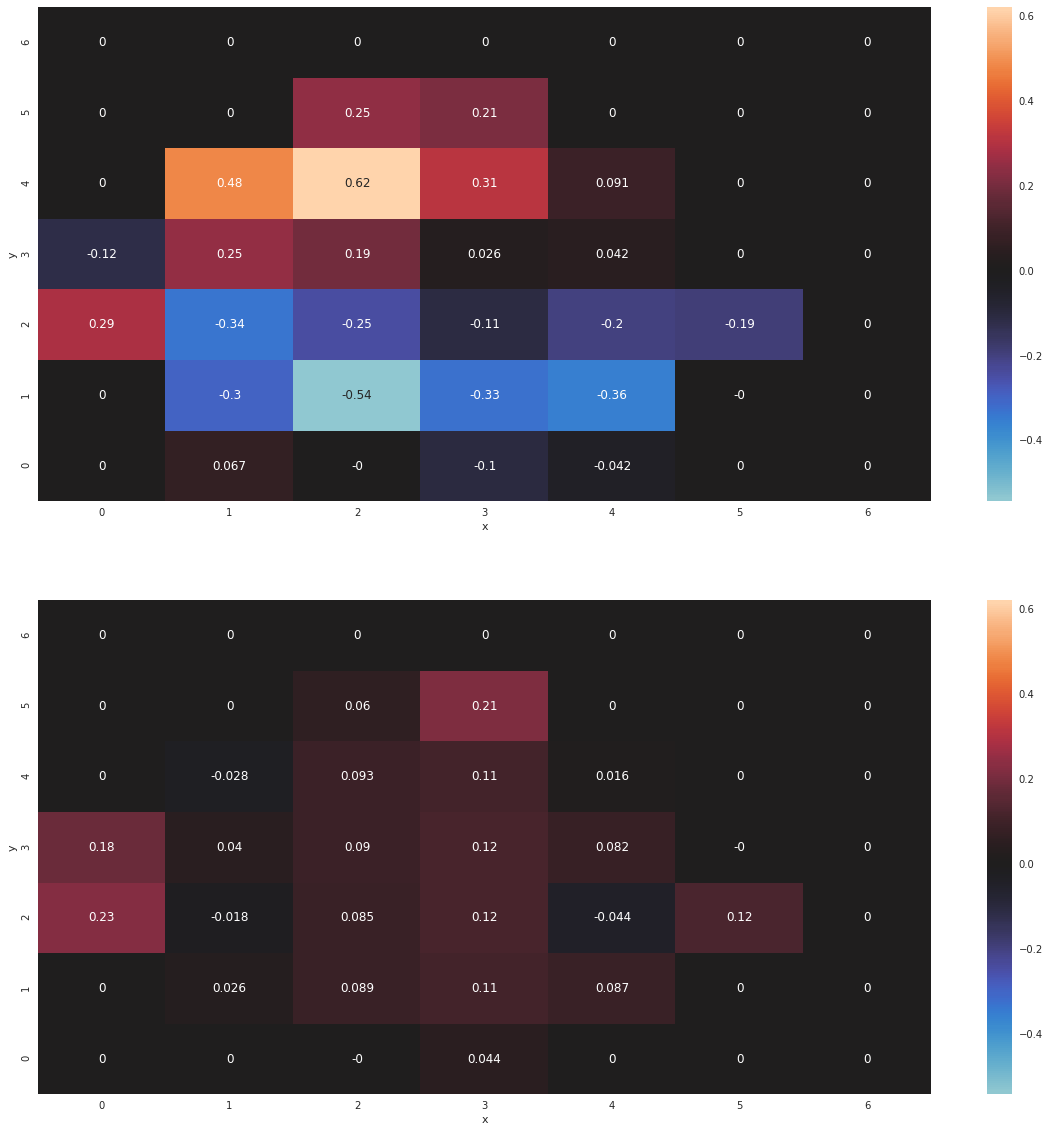

In [84]:
import seaborn as sns; sns.set()
fig, ax = plt.subplots(2, sharex=False, figsize=(20,20))
vmin = min(spatial_weights.min(), angular_weights.min())
vmax = max(spatial_weights.max(), angular_weights.max())
ax[0] = sns.heatmap(spatial_weights.T, ax=ax[0], center=0, vmin=vmin, vmax=vmax, annot=True)
ax[1] = sns.heatmap(angular_weights.T, ax=ax[1], center=0, vmin=vmin, vmax=vmax, annot=True)

ax[0].invert_yaxis()
ax[0].set_ylabel("y")
ax[0].set_xlabel("x")

ax[1].invert_yaxis()
ax[1].set_ylabel("y")
ax[1].set_xlabel("x")

fig.savefig("../../figures/linear_rf.pdf", bbox_inches='tight', transparent=True)

In [87]:
from sklearn import metrics
enet_r2 = metrics.r2_score(y_true=y_np, y_pred=linear.predict(X_np), )
enet_r2_test = metrics.r2_score(y_true=y_np_test, y_pred=linear.predict(X_np_test), )

#nn_yhat = model(Variable(X.cuda())).cpu().data.numpy()
#nn_r2 = metrics.r2_score(y_true=y_np, y_pred=nn_yhat)

mean_yhat = np.ones_like(y_np) * y_np.mean()
mean_r2 = metrics.r2_score(y_true=y_np, y_pred=mean_yhat)

enet_r2, enet_r2_test, nn_r2, mean_r2

(0.16451784671875391, 0.060228060334334144, -0.003412547719546799, 0.0)

In [54]:
from scipy import stats
stats.spearmanr(y_np, nn_yhat), stats.spearmanr(y_np, linear.predict(X_np)),\
stats.spearmanr(y_np_test, linear.predict(X_np_test))

(SpearmanrResult(correlation=0.017653995979904521, pvalue=0.14611789653870766),
 SpearmanrResult(correlation=0.48956880115879475, pvalue=0.0),
 SpearmanrResult(correlation=0.32046591591561285, pvalue=1.8026113173780643e-42))

In [55]:
stats.pearsonr(y_np, nn_yhat.reshape(-1)), stats.pearsonr(y_np, linear.predict(X_np)),\
stats.pearsonr(y_np_test, linear.predict(X_np_test))

((0.011603013427378569, 0.33948343692075911),
 (0.45161270962010586, 0.0),
 (0.25986116827821615, 5.274733777153746e-28))

In [197]:
np.rad2deg(linear.predict(X_np[1000:1020]))

array([-16.93112085, -31.76326696,  -7.64529782,  -3.59212962,
        -4.06401436,  -3.03448031,  -3.41204614,  -3.85854797,
        -2.05692904,   0.04531027, -13.32324271, -11.836868  ,
       -10.23495848,   3.72818441,   2.9618917 ,   9.39424329,
         8.85686787,  12.569053  ,  15.91229089,  13.98130447])

In [201]:
np.rad2deg(model(Variable(X[:,1100:1150,:]).cuda()).data.cpu().numpy().reshape(-1))

array([ 13.80802822,  10.46589947,  -6.35628891,  -9.49772167,
        10.11976242,  -4.03365898,   2.3268702 ,   9.58086395,
         8.00052357,  13.56545448,  -0.81038898,  -3.48391795,
         4.15974474,  10.85007858,   7.46649361,  -4.04448795,
        -0.87230808,  -1.08330667,  29.10732079,  30.06996727,
        46.64704514,  56.5621376 ,  16.21183586,  19.98330116,
        -0.37831295,  -4.47730589,  -5.85468149,  -8.7481699 ,
        -9.49629879, -14.81051636,  -2.63900137,  -8.59558868,
         7.81731939,   3.75745678,  -4.61072588,   5.6056633 ,
        -1.69081569,   8.82342625,  -3.58107567,   3.2424984 ,
        11.85943508,  47.08305359, -32.27326202,  14.21996689,
        -5.65400362,  -3.99361491, -15.40697479,   8.74664307,
        -6.97970247,  -3.3785367 ], dtype=float32)

In [203]:
np.rad2deg(y_np[1100:1150])

array([  -6.94387084,   34.335279  ,    3.39304672,   28.22109172,
         16.23704332,    0.66334456,    6.92503317,    1.94032184,
          0.85628033,   29.80267326,   37.13291765,  -18.34427619,
          0.31463267,   15.24667952,   16.77373569,   -9.28099426,
        -10.38270033,  -25.38860203,   30.12810101,   32.21053524,
         56.39403233,   82.88513786,   59.62839159,   64.0813985 ,
          9.21820091,   14.25720022,   12.04301691,    5.64847079,
        -11.3775925 ,   12.29223682,    8.83359291,   15.41194281,
          5.55182023,   19.10348245,  -19.79179989, -108.67670058,
          0.91454867,   15.827109  ,  -10.20828462,   11.86007195,
         47.32717648,   38.78633055,  -21.73100156,    6.81715717,
         -0.83683478,   -5.00850941,   -6.60054455,   -7.75758543,
         -6.12008855,  -14.87951931])